In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from TCSPC import *
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect

### Monte Carlo method

Draw `n_photon` random variables (time) from a mono probability density function(pdf)
$$f(t) = \tau \cdot \exp{(-t/\tau)}$$
where $\tau$ is the lifetime (also mean). `rng.exponential()` is used to generate `n_photon` arrival times.

For simulating data of multi exponential decays with the form
$$N(t) = \sum_i A_i \exp{(-t/\tau_i)}$$
where $N$ is the number of photons, $A_i$ and $\tau_i$ is amplitude and lifetime of the $i$ th component
The pdf now becomes 
$$f(t) = \sum_i A_i \tau_i \cdot \exp{(-t/\tau_i)}$$
`rng.choice()` is used to generate an array of lifetimes of length `n_photon`, where the occurence is weighted by probabilities $A_i \tau_i$. `rng.exponential()` is then used to generate `n_photon` arrival times.

Arrival times are then binned to give decay curves

In [2]:
NADH = Simulation([0.75,0.25],[0.4,4]) #create NADH instance of simulation class
EGFP = Simulation([0.503,0.497],[3.07,2.43]) #EGFP
mCherry  = Simulation([0.83,0.17],[1.43,2.38]) #mCherry
demo_tau = np.linspace(0.2,2,10) #lifetime from 0.2 to 2 ns as demonstration
demo_amp = np.ones(10)/10
DEMO = Simulation(demo_amp,demo_tau)

#### Comparison of simulation data from Monte Carlo (MC) method and adding Poisson noise to exponential curve convolved with very sharp IRF

The data generated by both methods are similar

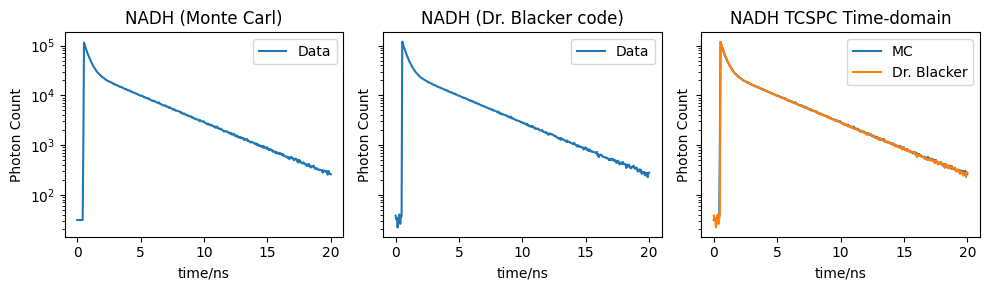

In [3]:
fig,ax = plt.subplots(1,3,figsize = (10,3),sharey = True)
ax = np.array(ax).flatten()
NADH.plot(ax[0],NADH.y)
NADH.plot(ax[1],NADH.y2)
NADH.plot(ax[2],NADH.y)
NADH.plot(ax[2],NADH.y2)
ax[0].set_title('NADH (Monte Carl)')
ax[1].set_title('NADH (Dr. Blacker code)')
ax[2].set_title('NADH TCSPC Time-domain')
handles, labels = ax[2].get_legend_handles_labels()
labels = ['MC','Dr. Blacker']
ax[2].legend(labels)
plt.tight_layout()

### DEMO

#### Brief Introduction to Simulation class object:

Input: <ul>
       <li>amp - an array of amplitudes/fractional intensity of mono-exponential components</li>
       <li>tau - an array of lifetimes of mono-exponential components</li>
       <li>IRF characteristics e.g. offset, irfwidth, bg, run_time can be modified,
       but have default values as in the given script</li>
       <li>Histogram properties, e.g. window - time-axis range (0-20ns), n_bins - number of bins (default 380)</li>
       </ul>
Methods: 

* `multi_exp_data` generate 1 multi exponential curve (1d array of size n_bins)\
* `MC_exp` : generate an array of mono exponential decay curves or 1 multi exponential curve using Monte Carlo method (i.e. random number generator, drawing from normal (IRF) and exponential distribution (decay))
* `plot`   : Plot the generated data. Need to pass a matplotlib `ax` object for plotting and y array (data to be plotted).\
Select data simulation function by setting MC =True (`MC_exp`) or False (`multi_exp_data`)

Call the `MC_exp()` method first to get data stored in `self.y`\
`multi_exp_data` would be stored in `self.y2`


### Deconvolution for non-linear fitting

Note at around 20ns, boundary effects, low-count statistic and noise would result in such poor behaviour. The deconvolved data should be trimmed before fitting

Discussed in meeting on 8 Frb, deconvolution using FFT is not recommended, as it might produce some unwanted artifects. Just use trimmed data for fitting 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Multi-exp')

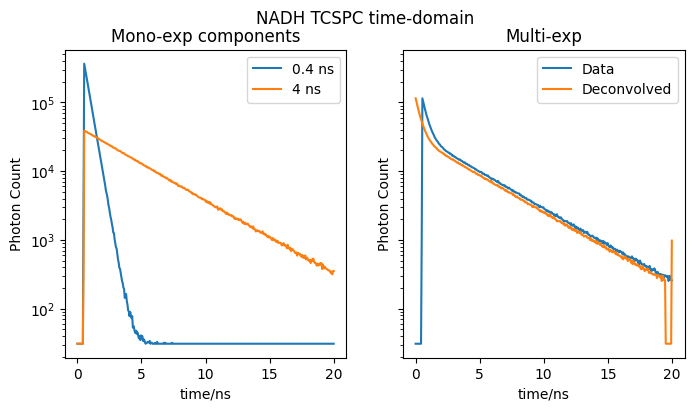

In [4]:
t, y_NADH = NADH.MC_exp()
fig,ax = plt.subplots(1,2,sharey = True, figsize = (8,4))
plt.suptitle('NADH TCSPC time-domain')
NADH.plot(ax[0],NADH.y_arr) #plot mono exp component
NADH.plot(ax[1],NADH.y) #plot multi exp 
NADH.plot(ax[1],NADH.y,deconv=True) #plot data deconvolved with IRF
handles, labels = ax[1].get_legend_handles_labels()
labels[-1] = 'Deconvolved'
ax[1].legend(labels)
ax[0].set_title('Mono-exp components')
ax[1].set_title('Multi-exp')

### Non-linear curve fit

1. Mono-exponential decay

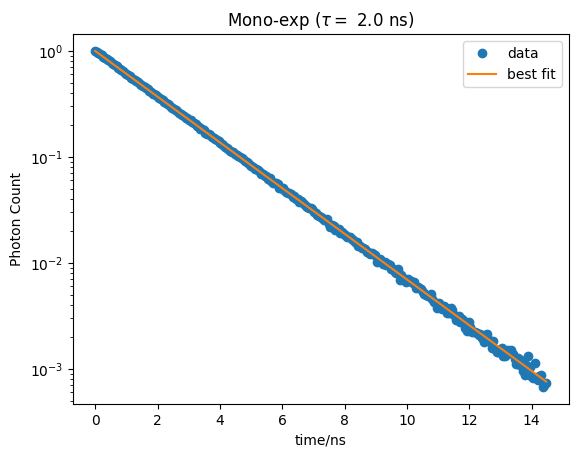

In [7]:
fig,ax = plt.subplots()
DEMO.fit(exp1,DEMO.y_arr[9],plot = True, guess = [DEMO.tau[9]],ax=ax) #fit and plot fitted curve
ax.set_title(rf'Mono-exp ($\tau =$ {DEMO.tau[9]} ns)')
DEMO.fit_result

2. Multi-exponential decay

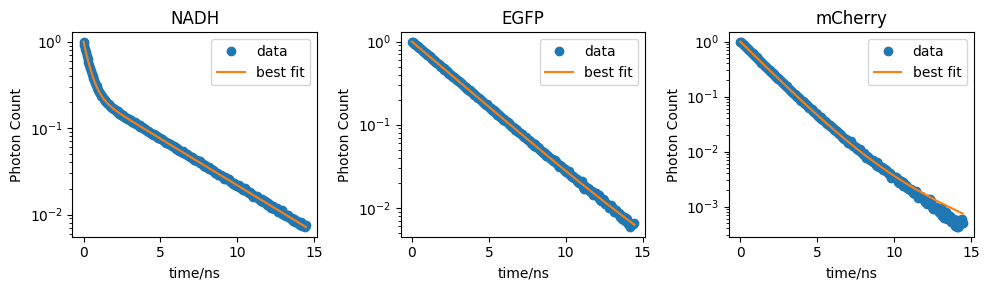

In [8]:
fig, ax = plt.subplots(1,3,figsize = (10,3))
NADH.fit(exp2,plot = True,ax=ax[0])
ax[0].set_title(rf'NADH')
EGFP.fit(exp2,plot = True,ax=ax[1])
ax[1].set_title(rf'EGFP')
mCherry.fit(exp2,plot = True,ax=ax[2])
ax[2].set_title(rf'mCherry')
plt.tight_layout()

In [66]:
pd.set_option('display.float_format', '{:.3g}'.format)
results = [NADH.fit_result]
# Extract the information from the result objects
attribute_names = ['chisqr', 'redchi', 'init_values', 'params_values', 'params_errors', 'correlation']
info_dict = {attribute_name: [] for attribute_name in attribute_names}

par_df = pd.concat({k: pd.Series(vars(v)).T for k, v in result.params.items()}, axis=1) #parameter attributes in pd.DataFrame
par_df = par_df.loc[['_val','init_value','stderr','correl']] #select value, initial value, error, and correlation 
par_df.loc['correl'] = [{k : f'{float(v):.3g}' for k,v in pair.items() }for pair in  par_df.loc['correl'].values] #round correlations

for result in results:
    info_dict['chisqr'].append(result.chisqr)
    info_dict['redchi'].append(result.redchi)
    info_dict['init_values'].append(result.init_values) 
#fitting stats info dataframe
info_df = pd.DataFrame(info_dict)
#MultiIndex
index_values = [(0, 'a'), ('X', 'b'), ('Y', 'c'), ('Y', 'd')]
pd.concat(info_df,par_df,)

,chisqr,redchi,init_values,params_values,params_errors,correlation
0,0.000227,8.34e-07,"{'A1': 0.75, 'tau1': 0.4, 'tau2': 4}","[0.7385306128770304, 0.4033800712045392, 4.019...","[0.00044819572584449494, 0.0005694342694545391...","[{'tau1': 0.7635263054137649, 'tau2': 0.875972..."


In [142]:
pd.concat({k: pd.Series(vars(v)).T for k, v in result.params.items()}, axis=1)

,A1,tau1,tau2
name,A1,tau1,tau2
user_data,None,None,None
init_value,0.75,0.4,4
min,0,0,0
max,inf,inf,inf
brute_step,None,None,None
vary,True,True,True
_expr,None,None,None
_expr_ast,None,None,None
_expr_eval,<asteval.asteval.Interpreter object at 0x122f5...,<asteval.asteval.Interpreter object at 0x122f5...,<asteval.asteval.Interpreter object at 0x122f5...


In [145]:
par_df = pd.concat({k: pd.Series(vars(v)).T for k, v in result.params.items()}, axis=1) #parameter attributes in pd.DataFrame
par_df = par_df.loc[['_val','init_value','stderr','correl']] #select value, initial value, error, and correlation 
par_df.loc['correl'] = [{k : f'{float(v):.3g}' for k,v in pair.items() }for pair in  par_df.loc['correl'].values] #round correlations
par_df.T

,_val,init_value,stderr,correl
A1,0.739,0.75,0.000448,"{'tau1': '0.764', 'tau2': '0.876'}"
tau1,0.403,0.4,0.000569,"{'A1': '0.764', 'tau2': '0.609'}"
tau2,4.02,4,0.00688,"{'A1': '0.876', 'tau1': '0.609'}"


In [136]:
for pair in par_df.loc['correl'].values:
    print(dict(pair.items()))

{'tau1': 0.7635263054137649, 'tau2': 0.8759728250438397}
{'A1': 0.7635263054137649, 'tau2': 0.6085870127749644}
{'A1': 0.8759728250438397, 'tau1': 0.6085870127749644}


In [62]:
param_names = list(NADH.fit_result.params.keys())
params = NADH.fit_result.params
for i in range(len(param_names)):
    for j in range(i+1, len(param_names)):
        name1 = param_names[i]
        name2 = param_names[j]
        print(f"{name1} {name2}: {NADH.fit_result.params[name1].correl[name2]}")

A1 tau1: 0.7635263054137649
A1 tau2: 0.8759728250438397
tau1 tau2: 0.6085870127749644


In [13]:
fit_report_str = NADH.fit_report
lines = fit_report_str.split('\n')
lines

['[[Model]]',
 '    Model(exp2)',
 '[[Fit Statistics]]',
 '    # fitting method   = leastsq',
 '    # function evals   = 13',
 '    # data points      = 275',
 '    # variables        = 3',
 '    chi-square         = 2.2679e-04',
 '    reduced chi-square = 8.3380e-07',
 '    Akaike info crit   = -3846.26704',
 '    Bayesian info crit = -3835.41672',
 '[[Variables]]',
 '    A1:    0.73853061 +/- 4.4820e-04 (0.06%) (init = 0.75)',
 '    tau1:  0.40338007 +/- 5.6943e-04 (0.14%) (init = 0.4)',
 '    tau2:  4.01900311 +/- 0.00688440 (0.17%) (init = 4)',
 '[[Correlations]] (unreported correlations are < 0.100)',
 '    C(A1, tau2)   = 0.876',
 '    C(A1, tau1)   = 0.764',
 '    C(tau1, tau2) = 0.609']

In [9]:
print(NADH.fit_report)
print(EGFP.fit_report)
print(mCherry.fit_report)

[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 275
    # variables        = 3
    chi-square         = 3.4218e-04
    reduced chi-square = 1.2580e-06
    Akaike info crit   = -3733.15660
    Bayesian info crit = -3722.30629
[[Variables]]
    A1:    0.73771190 +/- 5.5433e-04 (0.08%) (init = 0.75)
    tau1:  0.40782738 +/- 7.0731e-04 (0.17%) (init = 0.4)
    tau2:  4.02345315 +/- 0.00847008 (0.21%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = 0.877
    C(A1, tau1)   = 0.766
    C(tau1, tau2) = 0.611
[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 247
    # data points      = 275
    # variables        = 3
    chi-square         = 0.00130506
    reduced chi-square = 4.7980e-06
    Akaike info crit   = -3365.02651
    Bayesian info crit = -3354.17620
[[Variables]]
    A1:    8.0589e-04 +/- 0.00156172 (193.79%) (i

[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 275
    # variables        = 3
    chi-square         = 2.9558e-04
    reduced chi-square = 1.0867e-06
    Akaike info crit   = -3773.42196
    Bayesian info crit = -3762.57165
[[Variables]]
    A1:    0.73838915 +/- 5.1276e-04 (0.07%) (init = 0.75)
    tau1:  0.40381313 +/- 6.5065e-04 (0.16%) (init = 0.4)
    tau2:  4.01059533 +/- 0.00784735 (0.20%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = 0.876
    C(A1, tau1)   = 0.764
    C(tau1, tau2) = 0.609


Text(0.5, 0, 'time/ns')

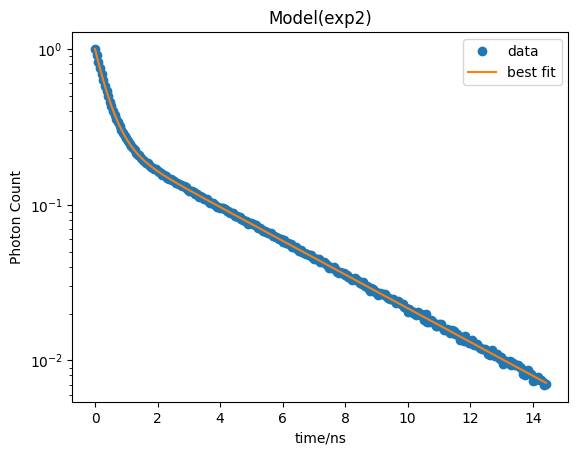

In [66]:
def exp1(t,tau):
    '''return mono-exponential exp(-t/tau)
       t    time array (ns)
       tau  lifetime   (ns)'''
    return np.exp(-t/tau)

def exp2(t,A1,tau1,tau2):
    '''returns bi-exponential A1*exp(-t/tau1) + (1-A1)*exp(-t/tau2)
       t    time array (ns)
       A1   amplitude 1
       tau1 lifetime 1 (ns)
       tau2 lifetime 2 (ns)
    '''
    return A1*np.exp(-t/tau1)+(1-A1)*np.exp(-t/tau2)

def exp_fit(func,tdata,ydata,guess,end = int((15/20*380)),bg = 10, run_time = 20*60):
    '''use least-square fit for given exponential function (exp1 or exp2)
       Inputs:
       func      exp function to be fitted 
       tdata     time array (non-trimmed)
       ydata     photon count (non-trimmed)
       guess     guess intial parameters for fitting
       end       trim the end point to avoid low count statistics
       bg        background count per s
       run_time  run_time (s)
       Outputs:
       result        lmfit result
       params_opt    fitted parameters
       chi2_red      reduced chi2
       fit_report    fit_report from lmfit
       '''
    model = Model(func)
    params = Parameters()
    # Get the parameter names and default values from the input function
    params_name = inspect.signature(exp2).parameters
    params_name = list(params_name.keys())[1:]  # Exclude 'x' from parameters
    for i,name in enumerate(params_name):
    # Add initial guess value for the parameter
        params.add(name,value=guess[i],min = 0)

    #Trim and scale data for fitting
    ydata = ydata-np.full(len(ydata),int(bg*run_time/len(tdata)))#subtract background from each bin
    max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
    tdata = tdata[:end-max_idx] #start from t = 0
    ydata = ydata[max_idx:end]  #start from max.
    ydata = ydata/ydata[0] # scale y data such that the beginning is 1 

    
    result = model.fit(ydata, params, t=tdata) #perform least squares fit
    params_opt = result.params #optimized params
    chi2= result.chisqr #chi squared
    chi2_red = result.chisqr/(len(tdata)-len(params))
    fit_report = result.fit_report()
    return result, params_opt, chi2_red, fit_report

# par, cov = curve_fit(exp2,tdata,ydata,p0 = [0.75,0.4,4]) #fit biexp decay
tdata, ydata = NADH.MC_exp_hist(deconv = False)
result, par_opt,chi2_red, fit_report = exp_fit(exp2,tdata,ydata,[0.75,0.4,4])
print(fit_report)
fig,ax = plt.subplots()
result.plot_fit(ax)
ax.set_yscale('log')
ax.set_ylabel('Photon Count')
ax.set_xlabel('time/ns')

In [48]:
if True:
     guess= [0.75,0.4,4]
     end = int((15/20*380)) #trim the data near the end, to avoid problems with low count statistics
     tdata, ydata = NADH.MC_exp_hist(deconv = False)
     ydata = ydata-np.full(len(ydata),NADH.bg*NADH.window/NADH.n_bins)
     max_idx = np.argmax(ydata) #index of data point with maximum photon count N(0)
     tdata = tdata[:end-max_idx] #start from t = 0
     ydata = ydata[max_idx:end]  #start from max.
     ydata = ydata/ydata[0] # normalize y data such that the beginning is 1 
    # Define model and perform the optimization
     model = Model(exp2)
     params = Parameters()
    # Get the parameter names and default values from the input function
     params_name = inspect.signature(exp2).parameters
     params_name = list(params_name.keys())[1:]  # Exclude 'x' from parameters
     for i,name in enumerate(params_name):
    # Add initial guess value for the parameter
         params.add(name,value=guess[i],min = 0)
     result = model.fit(ydata, params, t=tdata)
     params_opt = result.params #optimized params
     chi2= result.chisqr #chi squared
     chi2_red = result.chisqr/(len(tdata)-len(params))
     fit_report = result.fit_report()

<AxesSubplot:title={'center':'Model(exp2)'}, xlabel='t', ylabel='y'>

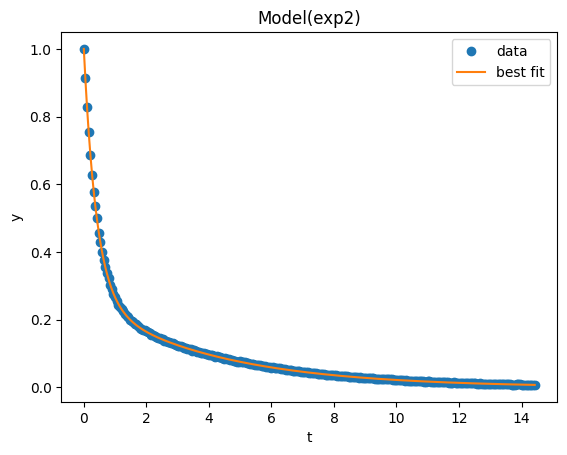

In [58]:
result.plot_fit()

### Effect of trimming  In FFT

The data is trimmed to $8 \tau$ as beyond that bg > emitted photon

Note that FFT of trimmed data is almost the same as FFT of original data, and even contain less data points
Both FFT curves deviates from the analytic solution of the Fourier Transform, which may be an artifect of using Discrete transform with not enough data points. Also this may be a result of noise in the data.

Therefore for phasor plots the data will not be trimmed

### Effect of lifetime
Agreement with analytic solution increases with lifetime 

### Effect of bin size
Agreement with analytic solution decreases with bin size (increases with bin number). However bin size cannot be changed in experimental setup.

Text(0, 0.5, 'Imaginary component of FFT')

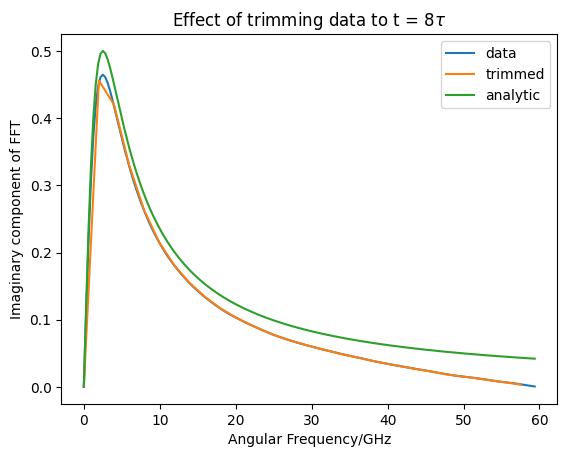

In [4]:
w, p = NADH.phasor_fft(multi = False)
w = w[:int(len(w)/2)]
tau0 = NADH.tau[0]
end = int(tau0*8*NADH.n_bins/NADH.window)
#trim data to 8 tau
y_trim = NADH.y_arr[0,:end]
ker_trim = NADH.ker[:end]
#FFT 
p2 = np.fft.fft(y_trim)/np.sum(y_trim)/np.fft.fft(ker_trim)*np.sum(ker_trim)
w2 = 2*np.pi*np.fft.fftfreq(len(ker_trim),NADH.t[end]/len(ker_trim))
p2 = p2[:int(len(w2)/2)] #just get +ve freq
w2  = w2[:int(len(w2)/2)]

plt.title(r'Effect of trimming data to t = 8$\tau$')
for i in range(1):
    plt.plot(w,-np.imag(p[i,:len(w)]),label = 'data')
    plt.plot(w2,-np.imag(p2),label = 'trimmed')
    plt.plot(w, np.imag(exp_FT(w,NADH.tau)[i]),label = 'analytic')
plt.legend()
plt.xlabel('Angular Frequency/GHz')
plt.ylabel('Imaginary component of FFT')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

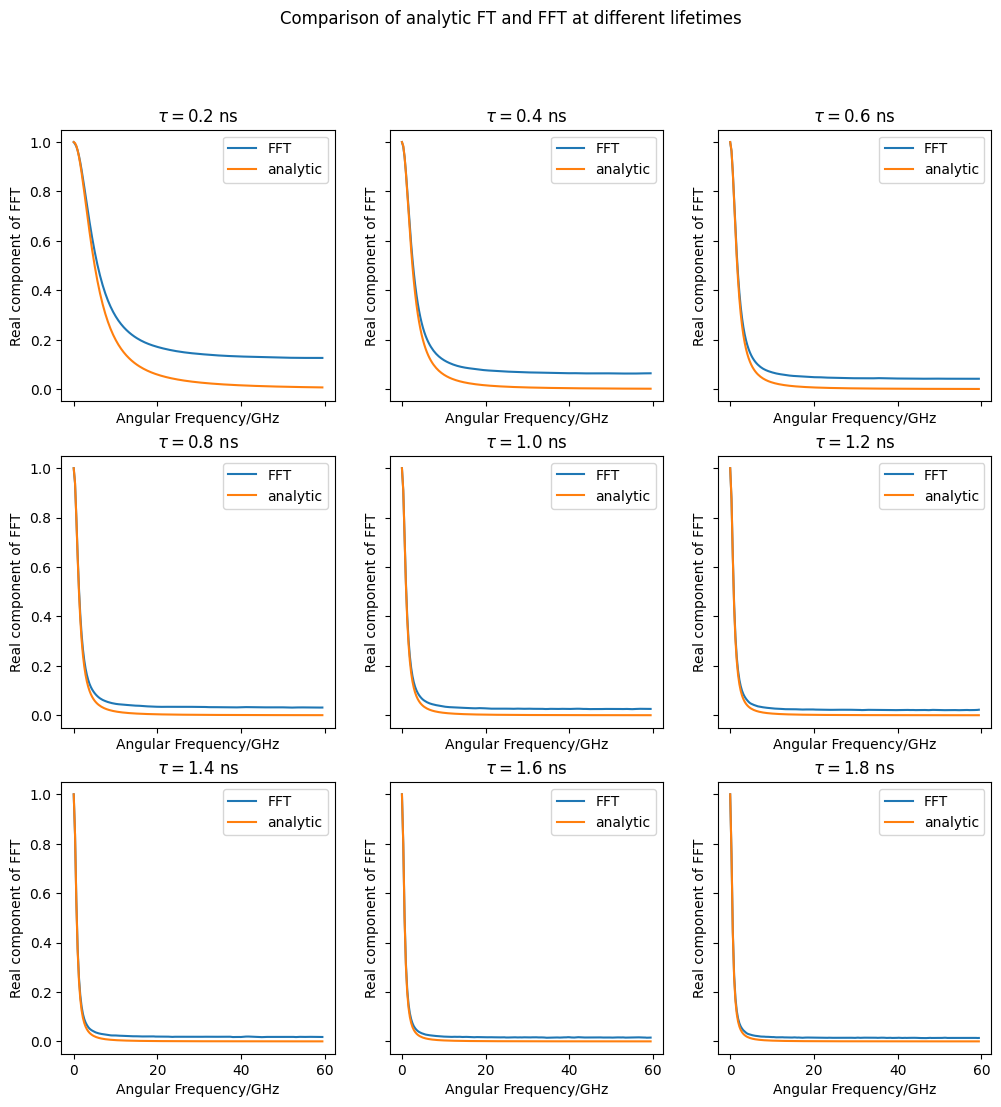

In [5]:
w,p = DEMO.phasor_fft(multi = False)
w = w[:190]
p = p[:,:190]
fig, ax_fft = plt.subplots(3,3,figsize= (12,12),sharex=True, sharey=True)
ax_fft = np.array(ax_fft).flatten()
plt.suptitle('Comparison of analytic FT and FFT at different lifetimes')
for i in range(9):
    ax_fft[i].plot(w,np.real(p[i,:]),label = 'FFT')
    ax_fft[i].plot(w, np.real(exp_FT(w,DEMO.tau)[i]),label = 'analytic')
    ax_fft[i].set_title(r'$\tau = $' + f'{DEMO.tau[i]:.1f} ns')
    ax_fft[i].legend()
    ax_fft[i].set_xlabel('Angular Frequency/GHz')
    ax_fft[i].set_ylabel('Real component of FFT')
plt.tight_layout

### Effect of Number of bins 

In experimental setup, this cannot be changed. So keep the number of bins at 380, and vary the acquisition time

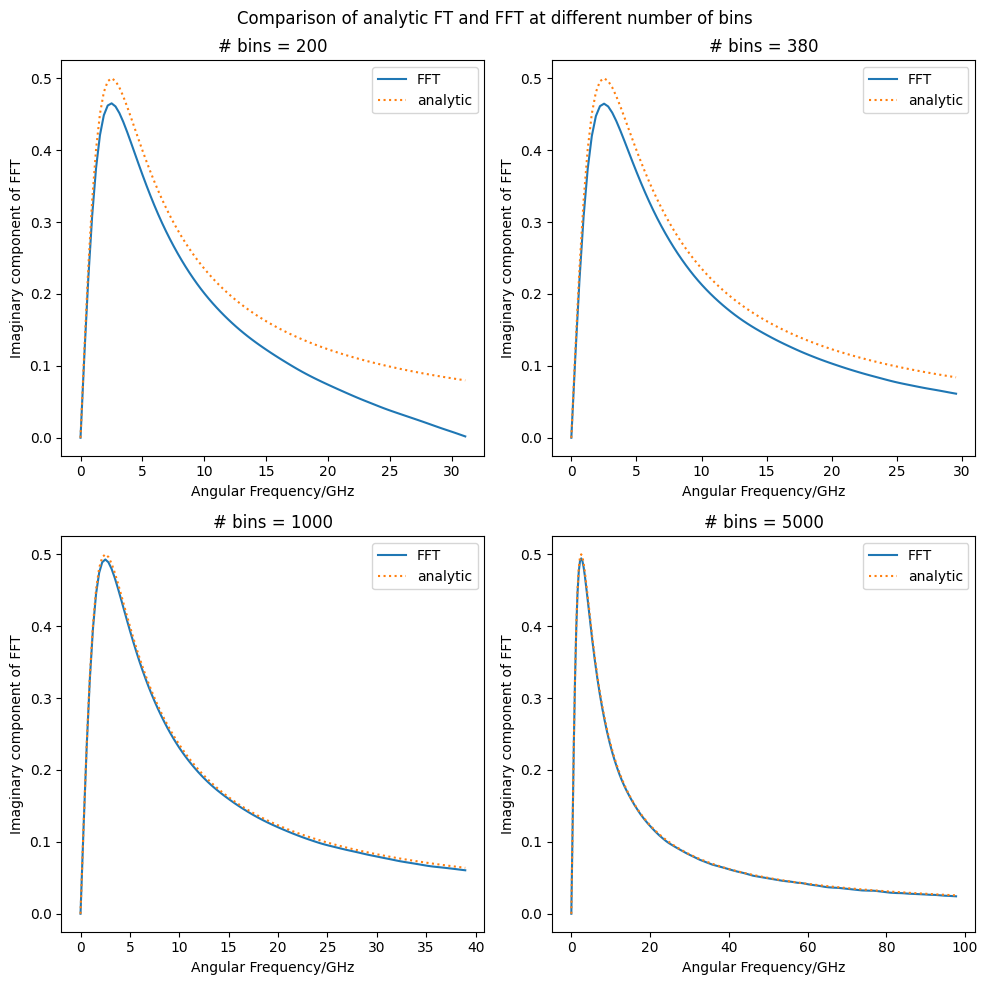

In [6]:
DEMO.MC_exp(multi = False)
n = 1 # select nth  lifetime
fig, ax_bin = plt.subplots(2,2,figsize = (10,10))
ax_bin = np.array(ax_bin).flatten()
n_bins = [200,380,1000,5000]
plt.suptitle('Comparison of analytic FT and FFT at different number of bins')
#Plot FFT of time-domain data with different n_bins
for i in range(len(n_bins)):
    w,p = DEMO.phasor_fft(multi = False,n_bins = n_bins[i]) 
    p = p[n,:]
    end = int(n_bins[i]/2**(i+1))
    ax_bin[i].set_title(f'# bins = {n_bins[i]}')
    ax_bin[i].plot(w[:end],-np.imag(p[:end]),label = 'FFT')
    ax_bin[i].plot(w[:end],np.imag(exp_FT(w[:end],DEMO.tau[n])[0]),':',label = 'analytic')
    ax_bin[i].set_xlabel('Angular Frequency/GHz')
    ax_bin[i].set_ylabel('Imaginary component of FFT')
    ax_bin[i].legend()

plt.tight_layout()

Note that the data points do not lie exactly on the universal circle even when the FFT curve (in frequency domnain) is very close to the analytic curve

How to quantify error in position in phasor plot?

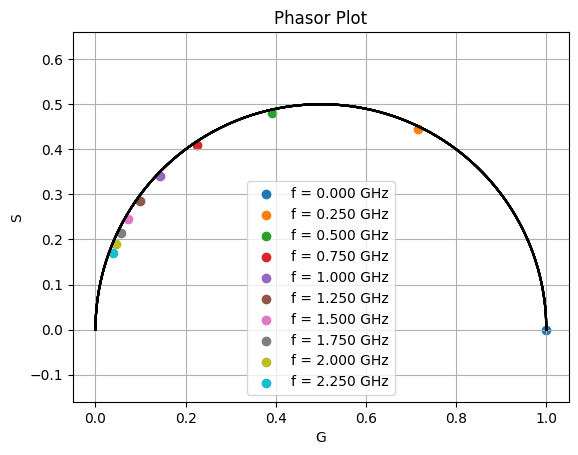

In [7]:
fig,ax = plt.subplots(1,1)
w0 = w[:50:5] #select a few angular frequencies to plot
phasor_plot(ax,w0,p[np.isin(w,w0)])


### Decomposing mult-exponential decays

In [7]:
w,phasor = NADH.phasor_fft(n_bins = 380)
phasor_solve(w,phasor)

{f1: 0.249398143678892,
 f2: 0.750601856321109,
 t1: -4.05680791438117,
 t2: -0.385803541762641}

In [16]:
par

array([0.73939522, 0.40845236, 4.04970114])

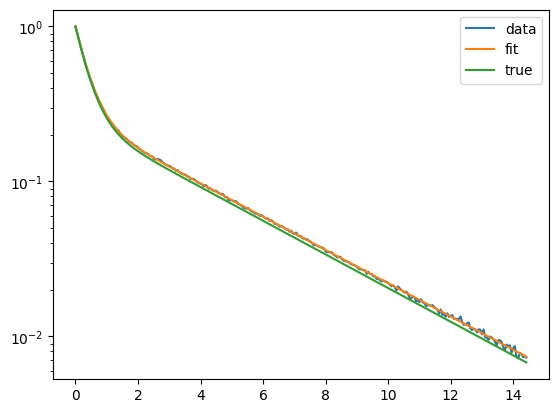

In [17]:
plt.plot(tdata,ydata,label = 'data')
plt.plot(tdata,bi_exp_fit(tdata,*par),label = 'fit')
plt.plot(tdata,bi_exp_fit(tdata,0.75,0.4,4),label = 'true')
plt.yscale('log')
plt.legend()

In [47]:
bins,y = NADH.MC_exp_hist(multi = True,n_bins = 380)
data_export = np.array([bins[15:],y[15:]])
np.savetxt('decay_data/NADH_trim.csv',data_export)

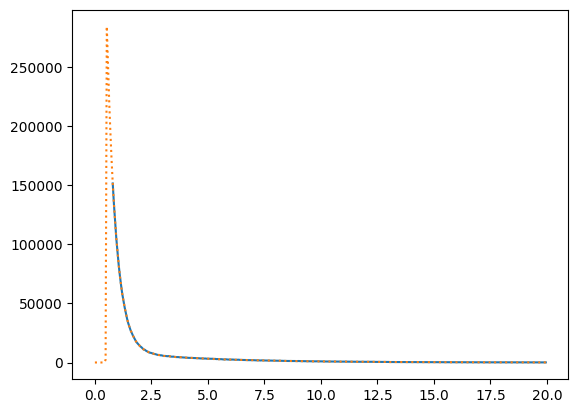

In [46]:
plt.plot(bins[15:],y[15:])
plt.plot(bins[:],y[:],':')

In [48]:
tfit,yfit =np.loadtxt('decay_data/NADH_trim.csv')

In [87]:
rng = np.random.default_rng()
tau_arr = rng.choice(NADH.tau,int(3e6),p = (NADH.amp*NADH.tau)/np.sum(NADH.amp*NADH.tau))
t_tot = rng.exponential(tau_arr)

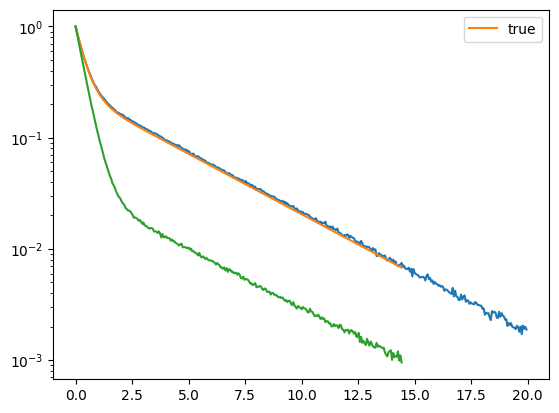

In [88]:
y, bins = np.histogram(t_tot,380,range = (0,20))
# y2, bins = np.histogram(t_tot2,380,range = (0,20))
# y = 0.75*y/max(y)+0.25*y2/max(y2)
plt.plot(bins[:-1],y/np.max(y))
plt.plot(tdata,bi_exp_fit(tdata,0.75,0.25,0.4,4),label = 'true')
plt.plot(tdata,ydata)
plt.yscale('log')
plt.legend()

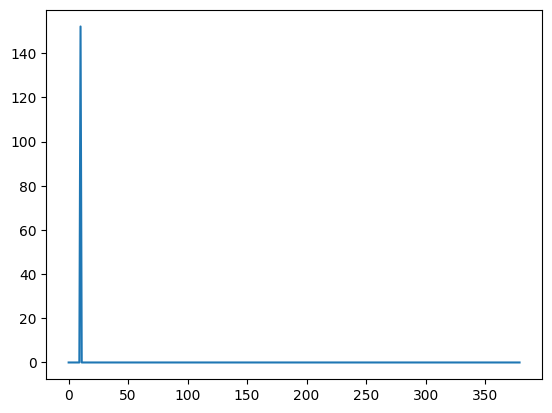

In [24]:
plt.plot(stats.norm.pdf(NADH.t,NADH.t0,1e-3))